In [19]:
import os
import sys
import pyreadr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.stats import wasserstein_distance

PROJECT_ROOT = os.path.abspath(os.path.join(sys.path[0], os.pardir))
sys.path.append(PROJECT_ROOT)
from src.datasets import ProbabilisticAnnotator, OracleAnnotator


# Check how closely simulated annotator mimics human annotators

In [20]:
hum_annotations_file = os.path.join(PROJECT_ROOT, 'data/raw/annotations/annotations_data_2023-08-30.rds')
hum_annotations = pyreadr.read_r(hum_annotations_file)[None]
print(f'Number of annotations: {len(hum_annotations)}')
# filter out user_rank UNKNOWN, user_id 9bc0d5e3-a871-4ffa-ae4f-1cbc44b0ea17, and NaN rel_delta_flow_cfs
hum_annotations = hum_annotations[hum_annotations['user_id'] != '9bc0d5e3-a871-4ffa-ae4f-1cbc44b0ea17']
hum_annotations = hum_annotations[hum_annotations['user_rank'] != 'UNKNOWN']
hum_annotations = hum_annotations[~hum_annotations['rel_delta_flow_cfs'].isna()]
print(f'Number of annotations after filtering: {len(hum_annotations)}')
hum_annotations.head(3)

/home/amritagupta/.conda/envs/streamflow/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:522: RuntimeWarning: invalid value encountered in multiply
  fvalues = (arg * mult).astype("f8", copy=False)
/home/amritagupta/.conda/envs/streamflow/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:522: RuntimeWarning: invalid value encountered in multiply
  fvalues = (arg * mult).astype("f8", copy=False)


Number of annotations: 190695
Number of annotations after filtering: 51636


,user_rank,comment,left.imageId,left.attributes,right.imageId,right.attributes,pair_id,annotation_id,user_id,user_id_short,...,right.url,right.timestamp,delta_flow_cfs,avg_flow_cfs,rel_delta_flow_cfs,true_rank,user_rank_lr,both_daytime,both_nighttime,one_nighttime
1,LEFT,NaN,694964,,898885,,2,101,e79e6f08-6652-4db1-bde7-b100b9d9e045,e79e6,...,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,2022-09-28 17:00:14,3.591184,1.795592,2.000000,LEFT,LEFT,True,True,True
7,SAME,NaN,898751,DISCONNECTED,825965,DISCONNECTED,8,101,e79e6f08-6652-4db1-bde7-b100b9d9e045,e79e6,...,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,2022-09-09 14:00:50,0.147101,0.074048,1.986554,RIGHT,NaN,True,False,True
8,SAME,NaN,698890,,696513,,9,101,e79e6f08-6652-4db1-bde7-b100b9d9e045,e79e6,...,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,2022-06-01 15:46:10,4.616649,4.677277,0.987038,RIGHT,NaN,True,True,True


In [21]:
# simulate annotator
sim_annotator = ProbabilisticAnnotator()
annotation_to_label = {
    'LEFT': 1,
    'SAME': 0,
    'RIGHT': -1,
}
label_to_annotation = {v: k for k, v in annotation_to_label.items()}

sim_annotations = []
for _, annotation in tqdm(hum_annotations.iterrows(), total=len(hum_annotations)):
    left_disch, right_disch, rel_delta_disch = annotation['left.flow_cfs'], annotation['right.flow_cfs'], annotation['rel_delta_flow_cfs']
    hum_label = annotation_to_label[annotation['user_rank']]
    left_data = pd.Series({'flow_cfs': left_disch})
    right_data = pd.Series({'flow_cfs': right_disch})
    sim_label = sim_annotator.annotate_pair([left_data, right_data], 'flow_cfs')
    sim_annotations.append({
        'rel_delta_flow_cfs': rel_delta_disch,
        'sim_rank': label_to_annotation[sim_label],
        'true_rank': annotation['true_rank'],
        'left.imageId': annotation['left.imageId'],
        'right.imageId': annotation['right.imageId'],
    })
sim_annotations = pd.DataFrame(sim_annotations)

# simulate oracle
oracle_annotator = OracleAnnotator()
oracle_annotations = []
for _, annotation in tqdm(hum_annotations.iterrows(), total=len(hum_annotations)):
    left_disch, right_disch, rel_delta_disch = annotation['left.flow_cfs'], annotation['right.flow_cfs'], annotation['rel_delta_flow_cfs']
    hum_label = annotation_to_label[annotation['user_rank']]
    left_data = pd.Series({'flow_cfs': left_disch})
    right_data = pd.Series({'flow_cfs': right_disch})
    oracle_label = oracle_annotator.annotate_pair([left_data, right_data], 'flow_cfs')
    oracle_annotations.append({
        'rel_delta_flow_cfs': rel_delta_disch,
        'oracle_rank': label_to_annotation[oracle_label],
        'true_rank': annotation['true_rank'],
        'left.imageId': annotation['left.imageId'],
        'right.imageId': annotation['right.imageId'],
    })
oracle_annotations = pd.DataFrame(oracle_annotations)


  0%|          | 0/51636 [00:00<?, ?it/s]/home/amritagupta/ssdprivate/repos/fpe-model/src/datasets.py:353: RuntimeWarning: divide by zero encountered in scalar divide
  if (left_disch - right_dishc) / min_disch > self.margin:
 14%|█▍        | 7360/51636 [00:02<00:12, 3681.90it/s]/home/amritagupta/ssdprivate/repos/fpe-model/src/datasets.py:356: RuntimeWarning: divide by zero encountered in scalar divide
  elif (left_disch - right_dishc) / min_disch < -self.margin:
100%|██████████| 51636/51636 [00:13<00:00, 3726.72it/s]


In [22]:
# compute agreement
print('Human vs. simulated annotator')
joined = hum_annotations.merge(sim_annotations, on=['left.imageId', 'right.imageId']) # BUG: why do 6 rows get dropped?
overall_agree = len(joined[joined['sim_rank'] == joined['user_rank']]) / len(joined)
same_agree = len(joined[(joined['sim_rank'] == joined['user_rank']) & (joined['user_rank'] == 'SAME')]) / len(joined[joined['user_rank'] == 'SAME'])
lr_agree = len(joined[(joined['sim_rank'] == joined['user_rank']) & (joined['user_rank'] != 'SAME')]) / len(joined[joined['user_rank'] != 'SAME'])
print(f'Overall agreement: {overall_agree}')
print(f'Same agreement: {same_agree}')
print(f'Left/right agreement: {lr_agree}')

print('Human vs. oracle annotator')
joined = hum_annotations.merge(oracle_annotations, on=['left.imageId', 'right.imageId'])
overall_agree = len(joined[joined['oracle_rank'] == joined['user_rank']]) / len(joined)
same_agree = len(joined[(joined['oracle_rank'] == joined['user_rank']) & (joined['user_rank'] == 'SAME')]) / len(joined[joined['user_rank'] == 'SAME'])
lr_agree = len(joined[(joined['oracle_rank'] == joined['user_rank']) & (joined['user_rank'] != 'SAME')]) / len(joined[joined['user_rank'] != 'SAME'])
print(f'Overall agreement: {overall_agree}')
print(f'Same agreement: {same_agree}')
print(f'Left/right agreement: {lr_agree}')


Human vs. simulated annotator
Overall agreement: 0.653131172301615
Same agreement: 0.48639434307721446
Left/right agreement: 0.726894394324498
Human vs. oracle annotator
Overall agreement: 0.6492389915185315
Same agreement: 0.034661279121156637
Left/right agreement: 0.9211239281624445


/tmp/ipykernel_1441239/1190022200.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hum_annotations_lr.user_rank = hum_annotations_lr.user_rank.cat.remove_categories('UNKNOWN') # for comparing user_rank and true_rank later


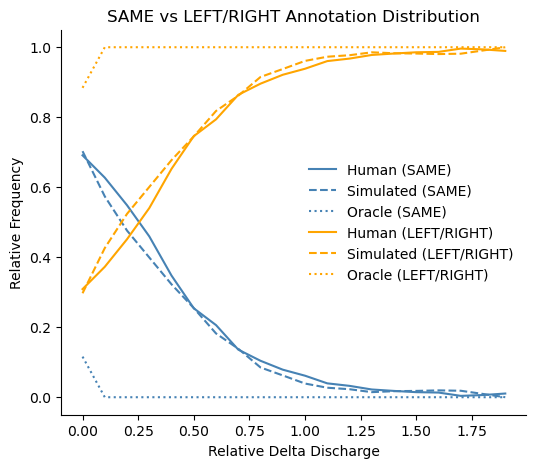

In [23]:
# compute annotation counts per bin
# SAME vs LEFT/RIGHT
hum_annotations_same = hum_annotations[hum_annotations['user_rank'] == 'SAME']
hum_annotations_lr = hum_annotations[hum_annotations['user_rank'].isin(['LEFT', 'RIGHT'])]
hum_annotations_lr.user_rank = hum_annotations_lr.user_rank.cat.remove_categories('UNKNOWN') # for comparing user_rank and true_rank later
hum_annotations_same_hist = np.histogram(hum_annotations_same['rel_delta_flow_cfs'], bins=np.arange(0, 2.1, 0.1))
hum_annotations_lr_hist = np.histogram(hum_annotations_lr['rel_delta_flow_cfs'], bins=np.arange(0, 2.1, 0.1))
hum_annotations_tot = hum_annotations_same_hist[0] + hum_annotations_lr_hist[0]

sim_annotations_same = sim_annotations[sim_annotations['sim_rank'] == 'SAME']
sim_annotations_lr = sim_annotations[sim_annotations['sim_rank'].isin(['LEFT', 'RIGHT'])]
sim_annotations_same_hist = np.histogram(sim_annotations_same['rel_delta_flow_cfs'], bins=np.arange(0, 2.1, 0.1))
sim_annotations_lr_hist = np.histogram(sim_annotations_lr['rel_delta_flow_cfs'], bins=np.arange(0, 2.1, 0.1))
sim_annotations_tot = sim_annotations_same_hist[0] + sim_annotations_lr_hist[0]

oracle_annotations_same = oracle_annotations[oracle_annotations['oracle_rank'] == 'SAME']
oracle_annotations_lr = oracle_annotations[oracle_annotations['oracle_rank'].isin(['LEFT', 'RIGHT'])]
oracle_annotations_same_hist = np.histogram(oracle_annotations_same['rel_delta_flow_cfs'], bins=np.arange(0, 2.1, 0.1))
oracle_annotations_lr_hist = np.histogram(oracle_annotations_lr['rel_delta_flow_cfs'], bins=np.arange(0, 2.1, 0.1))
oracle_annotations_tot = oracle_annotations_same_hist[0] + oracle_annotations_lr_hist[0]

# plot
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(hum_annotations_same_hist[1][:-1], hum_annotations_same_hist[0]/hum_annotations_tot, label='Human (SAME)', color='steelblue')
ax.plot(sim_annotations_same_hist[1][:-1], sim_annotations_same_hist[0]/sim_annotations_tot, label='Simulated (SAME)', color='steelblue', linestyle='--')
ax.plot(oracle_annotations_same_hist[1][:-1], oracle_annotations_same_hist[0]/oracle_annotations_tot, label='Oracle (SAME)', color='steelblue', linestyle=':')
ax.plot(hum_annotations_lr_hist[1][:-1], hum_annotations_lr_hist[0]/hum_annotations_tot, label='Human (LEFT/RIGHT)', color='orange')
ax.plot(sim_annotations_lr_hist[1][:-1], sim_annotations_lr_hist[0]/sim_annotations_tot, label='Simulated (LEFT/RIGHT)', color='orange', linestyle='--')
ax.plot(oracle_annotations_lr_hist[1][:-1], oracle_annotations_lr_hist[0]/oracle_annotations_tot, label='Oracle (LEFT/RIGHT)', color='orange', linestyle=':')
ax.set_xlabel('Relative Delta Discharge')
ax.set_ylabel('Relative Frequency')
ax.set_title('SAME vs LEFT/RIGHT Annotation Distribution')
ax.legend(frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()


In [24]:
wd_same_sim = wasserstein_distance(hum_annotations_same_hist[0]/hum_annotations_tot, sim_annotations_same_hist[0]/sim_annotations_tot)
wd_same_oracle = wasserstein_distance(hum_annotations_same_hist[0]/hum_annotations_tot, oracle_annotations_same_hist[0]/oracle_annotations_tot)
print(f'Wasserstein Distance between Human and Simulated Annotator: {wd_same_sim:.3f}')
print(f'Wasserstein Distance between Human and Oracle Annotator: {wd_same_oracle:.3f}')


Wasserstein Distance between Human and Simulated Annotator: 0.018
Wasserstein Distance between Human and Oracle Annotator: 0.178


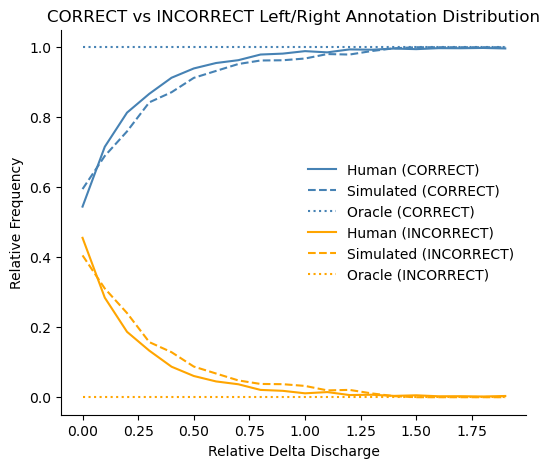

In [25]:
# compute annotation counts per bin
# CORRECT vs INCORRECT | LEFT/RIGHT
hum_annotations_lr_correct = hum_annotations_lr[hum_annotations_lr['user_rank'] == hum_annotations_lr['true_rank']].copy()
hum_annotations_lr_incorrect = hum_annotations_lr[hum_annotations_lr['user_rank'] != hum_annotations_lr['true_rank']].copy().reset_index(drop=True)
hum_annotations_lr_correct_hist = np.histogram(hum_annotations_lr_correct['rel_delta_flow_cfs'], bins=np.arange(0, 2.1, 0.1))
hum_annotations_lr_incorrect_hist = np.histogram(hum_annotations_lr_incorrect['rel_delta_flow_cfs'], bins=np.arange(0, 2.1, 0.1))
hum_annotations_lr_tot = hum_annotations_lr_correct_hist[0] + hum_annotations_lr_incorrect_hist[0]

sim_annotations_lr_correct = sim_annotations_lr[sim_annotations_lr['sim_rank'] == sim_annotations_lr['true_rank']]
sim_annotations_lr_incorrect = sim_annotations_lr[sim_annotations_lr['sim_rank'] != sim_annotations_lr['true_rank']]
sim_annotations_lr_correct_hist = np.histogram(sim_annotations_lr_correct['rel_delta_flow_cfs'], bins=np.arange(0, 2.1, 0.1))
sim_annotations_lr_incorrect_hist = np.histogram(sim_annotations_lr_incorrect['rel_delta_flow_cfs'], bins=np.arange(0, 2.1, 0.1))
sim_annotations_lr_tot = sim_annotations_lr_correct_hist[0] + sim_annotations_lr_incorrect_hist[0]

oracle_annotations_lr_correct = oracle_annotations_lr[oracle_annotations_lr['oracle_rank'] == oracle_annotations_lr['true_rank']]
oracle_annotations_lr_incorrect = oracle_annotations_lr[oracle_annotations_lr['oracle_rank'] != oracle_annotations_lr['true_rank']]
oracle_annotations_lr_correct_hist = np.histogram(oracle_annotations_lr_correct['rel_delta_flow_cfs'], bins=np.arange(0, 2.1, 0.1))
oracle_annotations_lr_incorrect_hist = np.histogram(oracle_annotations_lr_incorrect['rel_delta_flow_cfs'], bins=np.arange(0, 2.1, 0.1))
oracle_annotations_lr_tot = oracle_annotations_lr_correct_hist[0] + oracle_annotations_lr_incorrect_hist[0]


# plot
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(hum_annotations_lr_correct_hist[1][:-1], hum_annotations_lr_correct_hist[0]/hum_annotations_lr_tot, label='Human (CORRECT)', color='steelblue')
ax.plot(sim_annotations_lr_correct_hist[1][:-1], sim_annotations_lr_correct_hist[0]/sim_annotations_lr_tot, label='Simulated (CORRECT)', color='steelblue', linestyle='--')
ax.plot(oracle_annotations_lr_correct_hist[1][:-1], oracle_annotations_lr_correct_hist[0]/oracle_annotations_lr_tot, label='Oracle (CORRECT)', color='steelblue', linestyle=':')
ax.plot(hum_annotations_lr_incorrect_hist[1][:-1], hum_annotations_lr_incorrect_hist[0]/hum_annotations_lr_tot, label='Human (INCORRECT)', color='orange')
ax.plot(sim_annotations_lr_incorrect_hist[1][:-1], sim_annotations_lr_incorrect_hist[0]/sim_annotations_lr_tot, label='Simulated (INCORRECT)', color='orange', linestyle='--')
ax.plot(oracle_annotations_lr_incorrect_hist[1][:-1], oracle_annotations_lr_incorrect_hist[0]/oracle_annotations_lr_tot, label='Oracle (INCORRECT)', color='orange', linestyle=':')
ax.set_xlabel('Relative Delta Discharge')
ax.set_ylabel('Relative Frequency')
ax.set_title('CORRECT vs INCORRECT Left/Right Annotation Distribution')
ax.legend(frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()



In [26]:
wd_correct_sim = wasserstein_distance(hum_annotations_lr_correct_hist[0]/hum_annotations_lr_tot, sim_annotations_lr_correct_hist[0]/sim_annotations_lr_tot)
wd_correct_oracle = wasserstein_distance(hum_annotations_lr_correct_hist[0]/hum_annotations_lr_tot, oracle_annotations_lr_correct_hist[0]/oracle_annotations_lr_tot)
print(f'Wasserstein Distance between Human and Simulated Annotator: {wd_correct_sim:.3f}')
print(f'Wasserstein Distance between Human and Oracle Annotator: {wd_correct_oracle:.3f}')


Wasserstein Distance between Human and Simulated Annotator: 0.018
Wasserstein Distance between Human and Oracle Annotator: 0.069


# Repeat this analysis for single-site annotations

In [9]:
human_annotations_file = os.path.abspath(os.path.join(PROJECT_ROOT, '../../', 'data/Streamflow/fpe_stations/AVERYBB/AVERYBB-20230829/data/annotations.csv'))
h_annotations = pd.read_csv(human_annotations_file)
h_annotations = h_annotations[h_annotations['rank'] != 'UNKNOWN'] # leave out unknowns
h_annotations = h_annotations[h_annotations['user_id'] != '9bc0d5e3-a871-4ffa-ae4f-1cbc44b0ea17'] # leave out user id 9bc0d5e3-a871-4ffa-ae4f-1cbc44b0ea17
hum_annotations = hum_annotations[~hum_annotations['rel_delta_flow_cfs'].isna()] # leave out NaNs
print(f'Number of annotations: {len(h_annotations)}')

flow_images_file = os.path.abspath(os.path.join(PROJECT_ROOT, '../../', 'data/Streamflow/fpe_stations/AVERYBB/AVERYBB-20230829/data/flow-images.csv'))
flow_images = pd.read_csv(flow_images_file)


Number of annotations: 2039


In [27]:
s_annotations = []
for _, annotation in tqdm(h_annotations.iterrows(), total=len(h_annotations)):
    left_disch, right_disch, rel_delta_disch = annotation['left.flow_cfs'], annotation['right.flow_cfs'], annotation['rel_delta_flow_cfs']
    hum_label = annotation_to_label[annotation['rank']]
    left_data = pd.Series({'flow_cfs': left_disch})
    right_data = pd.Series({'flow_cfs': right_disch})
    sim_label = sim_annotator.annotate_pair([left_data, right_data], 'flow_cfs')
    s_annotations.append({
        'rel_delta_flow_cfs': rel_delta_disch,
        'sim_rank': label_to_annotation[sim_label],
        'true_rank': annotation['true_rank'],
        'left.imageId': annotation['left.imageId'],
        'right.imageId': annotation['right.imageId'],
    })
s_annotations = pd.DataFrame(s_annotations)

o_annotations = []
for _, annotation in tqdm(h_annotations.iterrows(), total=len(h_annotations)):
    left_disch, right_disch, rel_delta_disch = annotation['left.flow_cfs'], annotation['right.flow_cfs'], annotation['rel_delta_flow_cfs']
    hum_label = annotation_to_label[annotation['rank']]
    left_data = pd.Series({'flow_cfs': left_disch})
    right_data = pd.Series({'flow_cfs': right_disch})
    oracle_label = oracle_annotator.annotate_pair([left_data, right_data], 'flow_cfs')
    o_annotations.append({
        'rel_delta_flow_cfs': rel_delta_disch,
        'oracle_rank': label_to_annotation[oracle_label],
        'true_rank': annotation['true_rank'],
        'left.imageId': annotation['left.imageId'],
        'right.imageId': annotation['right.imageId'],
    })
o_annotations = pd.DataFrame(o_annotations)

100%|██████████| 2039/2039 [00:00<00:00, 3635.08it/s]


In [28]:
# compute agreement
print('Human vs. simulated annotator')
joined = h_annotations.merge(s_annotations, on=['left.imageId', 'right.imageId'])
overall_agree = len(joined[joined['sim_rank'] == joined['rank']]) / len(joined)
same_agree = len(joined[(joined['sim_rank'] == joined['rank']) & (joined['rank'] == 'SAME')]) / len(joined[joined['rank'] == 'SAME'])
lr_agree = len(joined[(joined['sim_rank'] == joined['rank']) & (joined['rank'] != 'SAME')]) / len(joined[joined['rank'] != 'SAME'])
print(f'Overall agreement: {overall_agree}')
print(f'Same agreement: {same_agree}')
print(f'Left/right agreement: {lr_agree}')

print('Human vs. oracle annotator')
joined = h_annotations.merge(o_annotations, on=['left.imageId', 'right.imageId'])
overall_agree = len(joined[joined['oracle_rank'] == joined['rank']]) / len(joined)
same_agree = len(joined[(joined['oracle_rank'] == joined['rank']) & (joined['rank'] == 'SAME')]) / len(joined[joined['rank'] == 'SAME'])
lr_agree = len(joined[(joined['oracle_rank'] == joined['rank']) & (joined['rank'] != 'SAME')]) / len(joined[joined['rank'] != 'SAME'])
print(f'Overall agreement: {overall_agree}')
print(f'Same agreement: {same_agree}')
print(f'Left/right agreement: {lr_agree}')


Human vs. simulated annotator
Overall agreement: 0.7238842569887199
Same agreement: 0.37995824634655534
Left/right agreement: 0.8294871794871795
Human vs. oracle annotator
Overall agreement: 0.7140755272192251
Same agreement: 0.014613778705636743
Left/right agreement: 0.9288461538461539


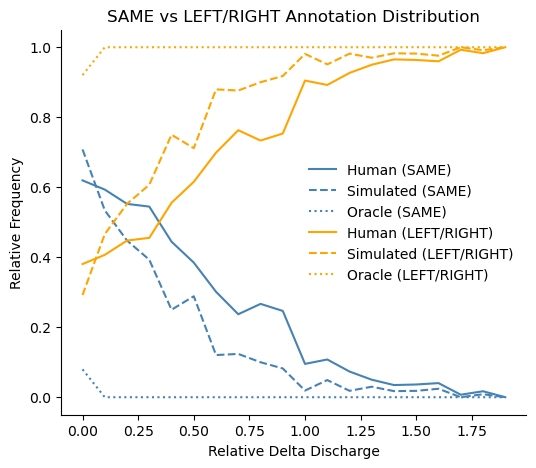

In [29]:
# compute annotation counts per bin
# SAME vs LEFT/RIGHT
h_same = h_annotations[h_annotations['rank'] == 'SAME']
h_ranked = h_annotations[h_annotations['rank'].isin(['LEFT', 'RIGHT'])]
h_same_hist = np.histogram(h_same['rel_delta_flow_cfs'], bins=np.arange(0, 2.1, 0.1))
h_ranked_hist = np.histogram(h_ranked['rel_delta_flow_cfs'], bins=np.arange(0, 2.1, 0.1))
h_tot_hist = h_ranked_hist[0] + h_same_hist[0]

# simulated annotator data
s_same = s_annotations[s_annotations['sim_rank'] == 'SAME']
s_ranked = s_annotations[s_annotations['sim_rank'].isin(['LEFT', 'RIGHT'])]
s_same_hist = np.histogram(s_same['rel_delta_flow_cfs'], bins=np.arange(0, 2.1, 0.1))
s_ranked_hist = np.histogram(s_ranked['rel_delta_flow_cfs'], bins=np.arange(0, 2.1, 0.1))
s_tot_hist = s_ranked_hist[0] + s_same_hist[0]

# oracle annotator data
o_same = o_annotations[o_annotations['oracle_rank'] == 'SAME']
o_ranked = o_annotations[o_annotations['oracle_rank'].isin(['LEFT', 'RIGHT'])]
o_same_hist = np.histogram(o_same['rel_delta_flow_cfs'], bins=np.arange(0, 2.1, 0.1))
o_ranked_hist = np.histogram(o_ranked['rel_delta_flow_cfs'], bins=np.arange(0, 2.1, 0.1))
o_tot_hist = o_ranked_hist[0] + o_same_hist[0]

# plot
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(h_same_hist[1][:-1], h_same_hist[0]/h_tot_hist, label='Human (SAME)', color='steelblue')
ax.plot(s_same_hist[1][:-1], s_same_hist[0]/s_tot_hist, label='Simulated (SAME)', color='steelblue', linestyle='--')
ax.plot(o_same_hist[1][:-1], o_same_hist[0]/o_tot_hist, label='Oracle (SAME)', color='steelblue', linestyle=':')
ax.plot(h_ranked_hist[1][:-1], h_ranked_hist[0]/h_tot_hist, label='Human (LEFT/RIGHT)', color='orange')
ax.plot(s_ranked_hist[1][:-1], s_ranked_hist[0]/s_tot_hist, label='Simulated (LEFT/RIGHT)', color='orange', linestyle='--')
ax.plot(o_ranked_hist[1][:-1], o_ranked_hist[0]/o_tot_hist, label='Oracle (LEFT/RIGHT)', color='orange', linestyle=':')
ax.set_xlabel('Relative Delta Discharge')
ax.set_ylabel('Relative Frequency')
ax.set_title('SAME vs LEFT/RIGHT Annotation Distribution')
ax.legend(frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()



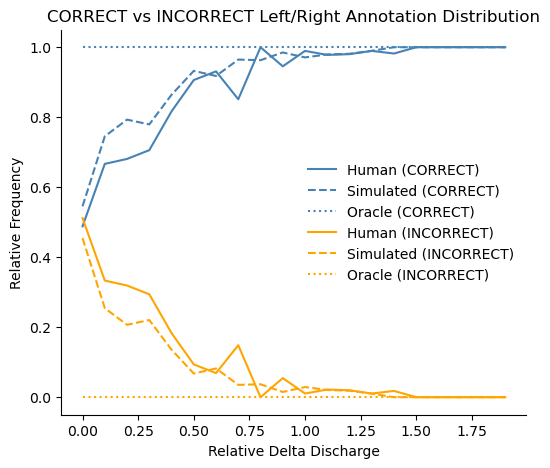

In [30]:
# compute annotation counts per bin
# CORRECT vs INCORRECT | LEFT/RIGHT
h_ranked_correct = h_ranked[h_ranked['rank'] == h_ranked['true_rank']].copy()
h_ranked_incorrect = h_ranked[h_ranked['rank'] != h_ranked['true_rank']].copy().reset_index(drop=True)
h_ranked_correct_hist = np.histogram(h_ranked_correct['rel_delta_flow_cfs'], bins=np.arange(0, 2.1, 0.1))
h_ranked_incorrect_hist = np.histogram(h_ranked_incorrect['rel_delta_flow_cfs'], bins=np.arange(0, 2.1, 0.1))
h_ranked_tot = h_ranked_correct_hist[0] + h_ranked_incorrect_hist[0]

s_ranked_correct = s_ranked[s_ranked['sim_rank'] == s_ranked['true_rank']]
s_ranked_incorrect = s_ranked[s_ranked['sim_rank'] != s_ranked['true_rank']]
s_ranked_correct_hist = np.histogram(s_ranked_correct['rel_delta_flow_cfs'], bins=np.arange(0, 2.1, 0.1))
s_ranked_incorrect_hist = np.histogram(s_ranked_incorrect['rel_delta_flow_cfs'], bins=np.arange(0, 2.1, 0.1))
s_ranked_tot = s_ranked_correct_hist[0] + s_ranked_incorrect_hist[0]

o_ranked_correct = o_ranked[o_ranked['oracle_rank'] == o_ranked['true_rank']]
o_ranked_incorrect = o_ranked[o_ranked['oracle_rank'] != o_ranked['true_rank']]
o_ranked_correct_hist = np.histogram(o_ranked_correct['rel_delta_flow_cfs'], bins=np.arange(0, 2.1, 0.1))
o_ranked_incorrect_hist = np.histogram(o_ranked_incorrect['rel_delta_flow_cfs'], bins=np.arange(0, 2.1, 0.1))
o_ranked_tot = o_ranked_correct_hist[0] + o_ranked_incorrect_hist[0]

# plot
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(h_ranked_correct_hist[1][:-1], h_ranked_correct_hist[0]/h_ranked_tot, label='Human (CORRECT)', color='steelblue')
ax.plot(s_ranked_correct_hist[1][:-1], s_ranked_correct_hist[0]/s_ranked_tot, label='Simulated (CORRECT)', color='steelblue', linestyle='--')
ax.plot(o_ranked_correct_hist[1][:-1], o_ranked_correct_hist[0]/o_ranked_tot, label='Oracle (CORRECT)', color='steelblue', linestyle=':')
ax.plot(h_ranked_incorrect_hist[1][:-1], h_ranked_incorrect_hist[0]/h_ranked_tot, label='Human (INCORRECT)', color='orange')
ax.plot(s_ranked_incorrect_hist[1][:-1], s_ranked_incorrect_hist[0]/s_ranked_tot, label='Simulated (INCORRECT)', color='orange', linestyle='--')
ax.plot(o_ranked_incorrect_hist[1][:-1], o_ranked_incorrect_hist[0]/o_ranked_tot, label='Oracle (INCORRECT)', color='orange', linestyle=':')
ax.set_xlabel('Relative Delta Discharge')
ax.set_ylabel('Relative Frequency')
ax.set_title('CORRECT vs INCORRECT Left/Right Annotation Distribution')
ax.legend(frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

